# Modeling Hodgkin Lymphoma and Associated Treatment Guidelines in OWL - Python Extension

#### Hannah Grossman (HLG), Matt Schwede (MSchwede), Julie Kong (ejkong)

#### load packages

In [1]:
!pip3 install owlready2
from owlready2 import *

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.


* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


## Create our custom ontology with owlready2

##### [owlready2 documation](https://owlready2.readthedocs.io/en/v0.36/), for those interested

In [2]:
onto = get_ontology("/Users/hgrossman/stanford/bmi210/HodgkinOntology.owl").load()
with onto:
    class ClinicalFeatures(Thing): pass
    class BSymptoms(ClinicalFeatures): pass

    class ExtraNodalRegion(ClinicalFeatures): pass
    class Distant(ExtraNodalRegion):pass
    class Localized(ExtraNodalRegion):pass
    class Spleen(ExtraNodalRegion):pass
 
    class LymphNodeRegion(ClinicalFeatures):pass
    class AboveDiaphragm(LymphNodeRegion):pass
    class BelowDiaphragm(LymphNodeRegion): pass
    
    class has_extra_nodal_region(ObjectProperty):pass
    class has_lymph_node_region(ObjectProperty):pass        
    class has_symptoms(ObjectProperty):pass

    class Stage(Thing): pass            
    class I(Stage):
        equivalent_to = [(Stage & has_extra_nodal_region.exactly(1, ExtraNodalRegion) & has_lymph_node_region.exactly(0, LymphNodeRegion)) |
                        (Stage & has_lymph_node_region.exactly(1, LymphNodeRegion) & has_extra_nodal_region.exactly(0, ExtraNodalRegion))]
        def stage(self): print(self.__class__)
    class IA(I):
        equivalent_to = [I & has_symptoms.exactly(0, BSymptoms)]      
    class IB(I):
        equivalent_to = [I & has_symptoms.some(BSymptoms)]        
    class II(Stage):
        equivalent_to = [(Stage & has_lymph_node_region.min(2, AboveDiaphragm) & has_lymph_node_region.exactly(0, BelowDiaphragm)) |
                        (Stage & has_lymph_node_region.min(2, BelowDiaphragm) & has_lymph_node_region.exactly(0, AboveDiaphragm)) |
                        (Stage & has_lymph_node_region.exactly(1, LymphNodeRegion) & has_extra_nodal_region.exactly(1, Localized))]
    class IIA(II):
        equivalent_to = [II & has_symptoms.exactly(0, BSymptoms)]       
    class IIB(II):
        equivalent_to = [II & has_symptoms.some(BSymptoms)]       
    class III(Stage):
        equivalent_to = [Stage & has_lymph_node_region.some(AboveDiaphragm) & has_lymph_node_region.some(BelowDiaphragm) & has_extra_nodal_region.only(Localized | Spleen)]        
    class IV(Stage):
        equivalent_to = [Stage & has_extra_nodal_region.some(Distant) & has_lymph_node_region.min(0, LymphNodeRegion)]

### create instances of of Lymph Node Regions, Extra Nodal Regions, and Symptoms, to determine the correct Stage

In [ ]:
thyroid = ExtraNodalRegion("thyroid")
liver = ExtraNodalRegion("liver")
kidney = ExtraNodalRegion("kidney")
localized = Localized("localized")
distant = Distant("distant")
distant2 = Distant("distant2")

laxilla = AboveDiaphragm("laxilla")
laxilla2 = AboveDiaphragm("laxilla2")
celiac = BelowDiaphragm("celiac")
celiac2 = BelowDiaphragm("celiac2")


AllDifferent([thyroid, liver, kidney, localized]) #extranodal
AllDifferent([laxilla, laxilla2, celiac, celiac2]) #lymph

fever = BSymptoms("fever")

### Create instances of specific stages and hope our Ontology reasons with them correctly

In [ ]:
ib = Stage("1b", has_extra_nodal_region = [thyroid], has_symptoms=[fever])
ia = Stage("1a", has_lymph_node_region = [laxilla])

iia = Stage("2a", has_lymph_node_region = [laxilla, laxilla2])
iib = Stage("2b", has_lymph_node_region = [laxilla, laxilla2], has_symptoms=[fever])
iia_ = Stage("2a_", has_lymph_node_region = [laxilla], has_extra_nodal_region=[localized])
iib_ = Stage("2b_", has_lymph_node_region = [laxilla], has_extra_nodal_region=[localized], has_symptoms=[fever])

iii = Stage("3", has_lymph_node_region=[celiac, laxilla], has_extra_nodal_region = [localized])
iv = Stage("4", has_extra_nodal_region = [distant, distant2])
iv_ = Stage("4_", has_extra_nodal_region = [distant], has_lymph_node_region=[celiac])

close_world(Stage)

#### function to save ontology, when ready

In [3]:
def save_ontology():
    onto.save("/Users/hgrossman/stanford/bmi210/HodgkinInstances.owl")

All of our Stage instances were correctly inferred by the Protege reasoner to their appropriate class

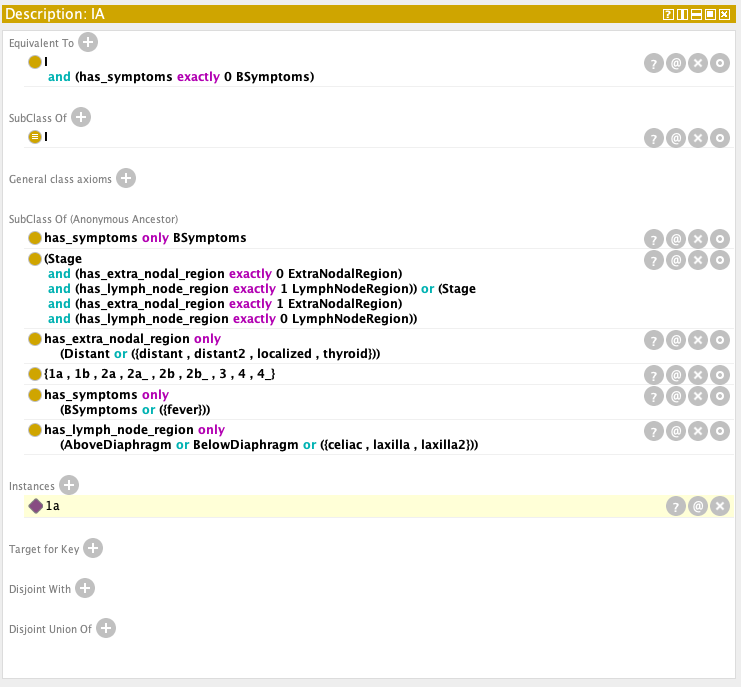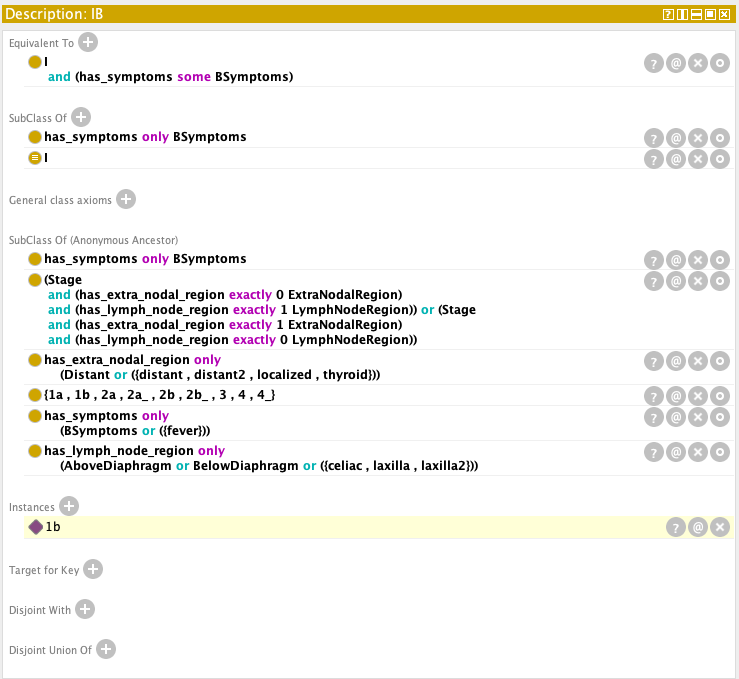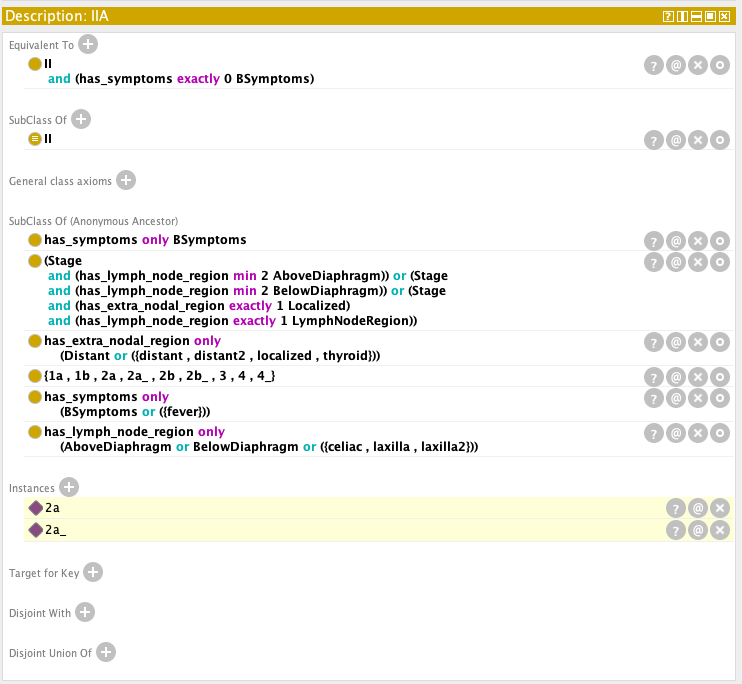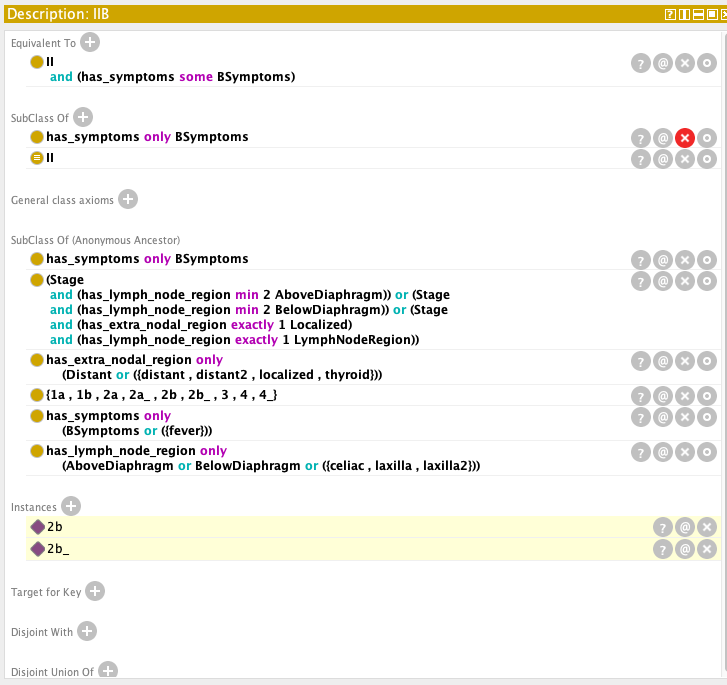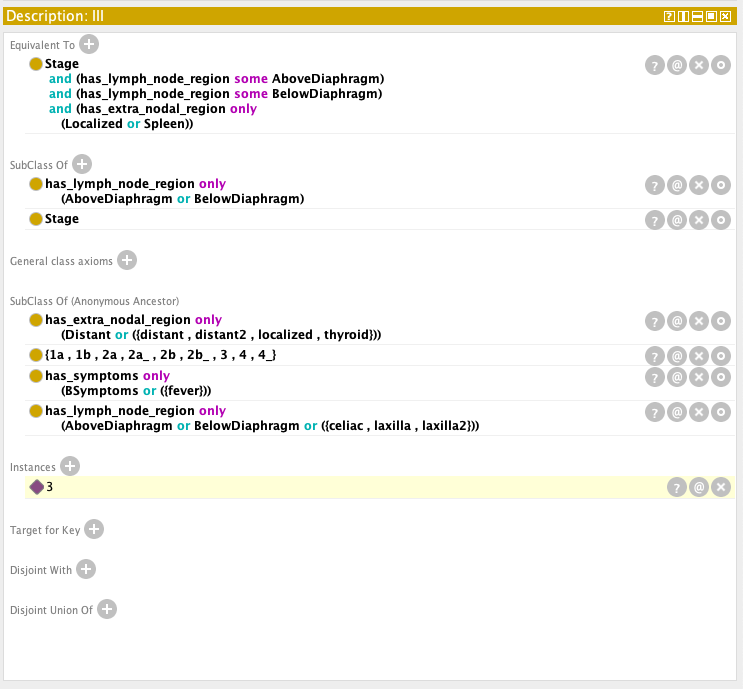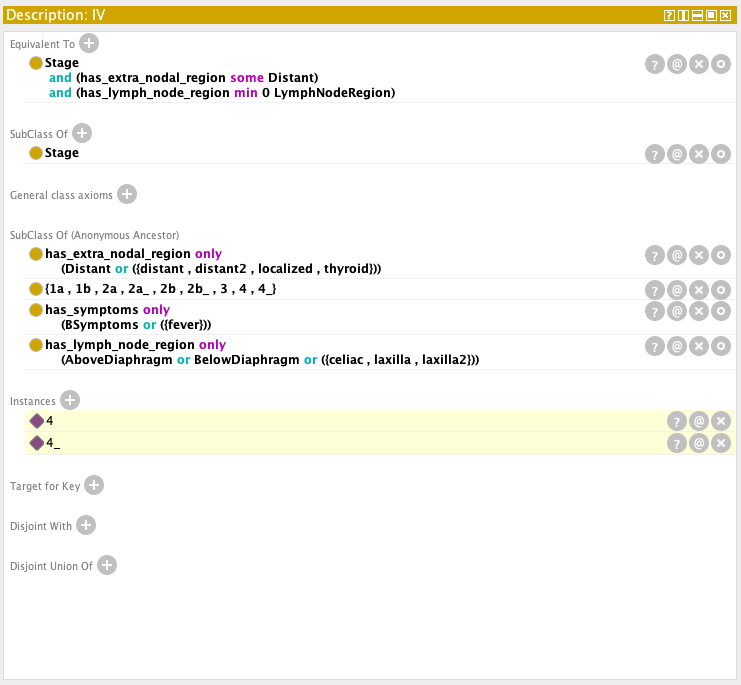

### Create a Patient Class to dynamically interact with our ontology

Based on the NCCN guidelines:
* we are limiting our `AboveDiaphragm` and `BelowDiaphragm nodes`, `'above'` and `'below'` respectively, to the following possible instances. 
* we are limiting creation of lymph nodes to Above and Below only, no general `LymphNodeRegion`
* any `localized`, `distant`, or `spleen` `ExtraNodalRegions` need to have the string names `'localized'`, `'distant'`, or `'spleen'`, respectively
* `BSymptoms` are limited to that of `'fever'`, `'night sweats'`, and `'weight loss'`
* classic histology includes: `"classic Hodgkin lymphoma"` , `"lymphocyte depleted"` , `"lymphocyte rich"` , `"mixed cellularity"`, `"nodular sclerosis"`
* nodular histology includes: `"nodular lymphocyte predominant"`

In [4]:
above = ['LAxilla', 'LCervicalSCL', 'LHilum', 'LICLSubpectoral', 'Mediastinum', 'RAxilla', 'RCervicalSCL', 'RHilum', 'RICLSubpectoral']
below = ['Liliac', 'LInguinalFemoral', 'Mesenteric', 'RInguinalFemoral', 'RIliac']
localized = ['localized']
distant = ['distant']
spleen = ["spleen"]
bsymptoms = ['fever', 'night sweats', 'weight loss']

classic_histology = ["classic Hodgkin lymphoma" , "lymphocyte depleted" , "lymphocyte rich" , "mixed cellularity" , "nodular sclerosis"]
nodular_histology = ["nodular lymphocyte predominant"]

In [53]:
class Patient:
    def __init__(self, name: str, age: int, gender: str):
        if gender not in ["Male", "Female"]:
            raise Exception(f"gender must be Male or Female, not {gender}")
        
        self.name = name
        self.lymph_node_regions = []
        self.symptoms = []
        self.extra_nodal_regions = []
        self.presence_of_bulky_mass = False
        self.presence_of_mediastinal_mass = False
        self.presence_of_bsymptoms = False
        self.histology = None
        self.stage = None

    def set_nodal_regions(self, nodes: list) -> None:
        for node in nodes:
            if node in above:
                self.set_above_diaphragm(node)
            elif node in below:
                self.set_below_diaphragm(node) 
            AllDifferent(self.lymph_node_regions)
    def set_above_diaphragm(self, node: str) -> None:
        onto_node = AboveDiaphragm(node)
        self.lymph_node_regions.append(onto_node)       
    def set_below_diaphragm(self, node: str) -> None:
        onto_node = BelowDiaphragm(node)
        self.lymph_node_regions.append(onto_node)                
    
    def set_symptoms(self, symptoms: list) -> None:
        for symptom in symptoms:
            if symptom in bsymptoms:
                self.presence_of_bsymptoms = True
                self.symptoms.append(BSymptoms(symptom))
            AllDifferent(self.symptoms)

    def set_extranodal_regions(self, nodes: list) -> None:
        for node in nodes:
            if node in localized:
                self.set_localized(node)
            elif node in distant:
                self.set_distant(node)
            elif node in spleen:
                self.set_spleen(node)
            AllDifferent(self.extra_nodal_regions)
    def set_localized(self, node: str) -> None:
        onto_node = Localized(node)
        self.extra_nodal_regions.append(onto_node)    
    def set_distant(self, node: str) -> None:
        onto_node = Distant(node)
        self.extra_nodal_regions.append(onto_node)        
    def set_spleen(self, node: str) -> None:
        onto_node = Spleen(node)
        self.extra_nodal_regions.append(onto_node)        
    
    def set_mediastinal_mass(self, mass_present: bool) -> None:
        self.presence_of_mediastinal_mass = mass_present
    
    def set_bulky_mass(self, mass_bulky: bool) -> None:
        # mass size greater than 10cm
        self.presence_of_bulky_mass = mass_bulky
        
    def set_all(self, lymph: list, extra: list, symptoms: list, bulky: bool, mediastinal: bool, histology: str):
        self.set_nodal_regions(lymph)
        self.set_extranodal_regions(extra)
        self.set_symptoms(symptoms)
        self.set_mediastinal_mass(mediastinal)
        self.set_bulky_mass(bulky)
        self.histology = histology
        
        Stage(self.name, has_lymph_node_region=self.lymph_node_regions, has_extra_nodal_region=self.extra_nodal_regions, has_symptoms=self.symptoms)
        
    def set_stage(self, stage: str):
        self.stage = stage

#### Create a Hodgkin Lymphoma class to determine Hodgkin Lymphoma classification based on patient histology & stage

In [89]:
def HodgkinLymphoma(patient: any):
    if patient.stage == 'IA' or patient.stage == 'IIA' or patient.stage == 'IB' or patient.stage == 'IIB':
        if patient.histology in classic_histology:
            if patient.presence_of_mediastinal_mass or patient.presence_of_bulky_mass or patient.presence_of_bsymptoms:
                print('Early Classic: Unfavorable')
            else:
                print('Early Classic: Favorable')
        elif patient.histology in nodular_histology:
            return print('Early Nodular Lymphocyte Predominant')
    elif patient.stage == 'III' or patient.stage == 'IV':
        if patient.histology in classic_histology:
            print('Late Classic')
        elif patient.histology in nodular_histology:
            print('Late Nodular Lymphocyte Predominant')

### Create Patients

##### create a patient Caroline with Stage IIB Early Classic: Unfavorable

In [90]:
caroline = Patient("Caroline", 22, "Female")

In [91]:
symptoms = ['fever', 'night sweats']
lymph_nodes = ['RCervicalSCL', 'RAxilla']

caroline.set_all(lymph_nodes, [], symptoms, None, None, "classic Hodgkin lymphoma")

##### create a patient Robert with Stage IB Early Nodular Lymphocyte Predominate

In [92]:
robert = Patient("Robert", 45, 'Male')

In [93]:
distant_nodes = ["localized"]
symptoms = ["weight loss"]

robert.set_all([], distant_nodes, symptoms, None, None, "nodular lymphocyte predominant")

##### create a patient Betsy with Stage III Late Classic

In [94]:
betsy = Patient("Betsy", 29, "Female")

In [95]:
lymph_nodes = ['LAxilla', 'LCervicalSCL', 'Mesenteric']
distant_nodes = ["spleen"]

betsy.set_all(lymph_nodes, distant_nodes, [], None, None, "nodular sclerosis")

Save our new protege file as HodgkinInstances.owl

In [96]:
close_world(Stage)
save_ontology()

In [97]:
onto2 = get_ontology("/Users/hgrossman/stanford/bmi210/HodgkinInstances.owl").load()

#### Figure out the inferred stage for our three patient instances

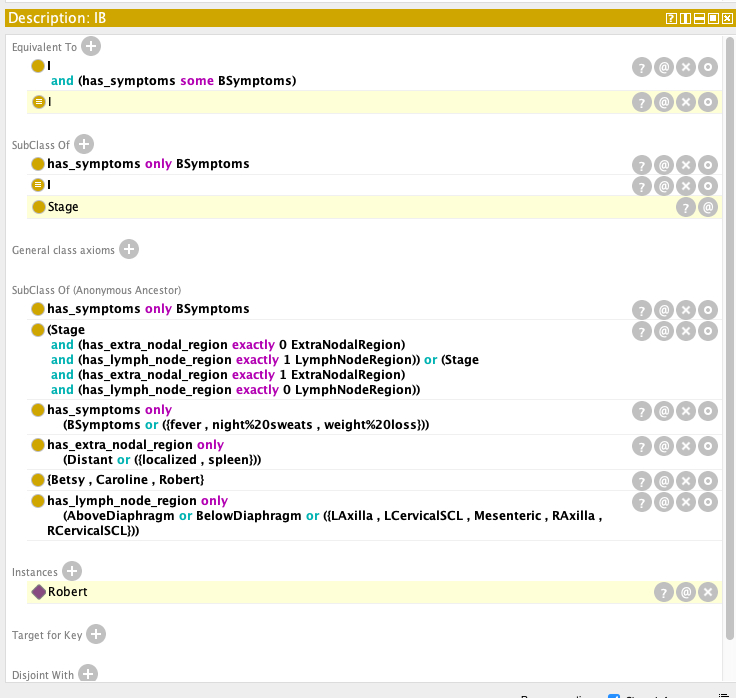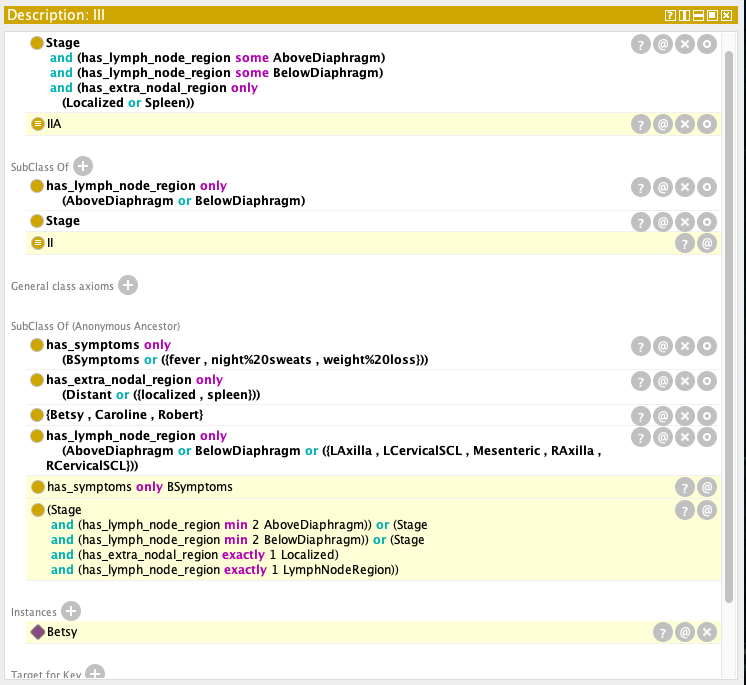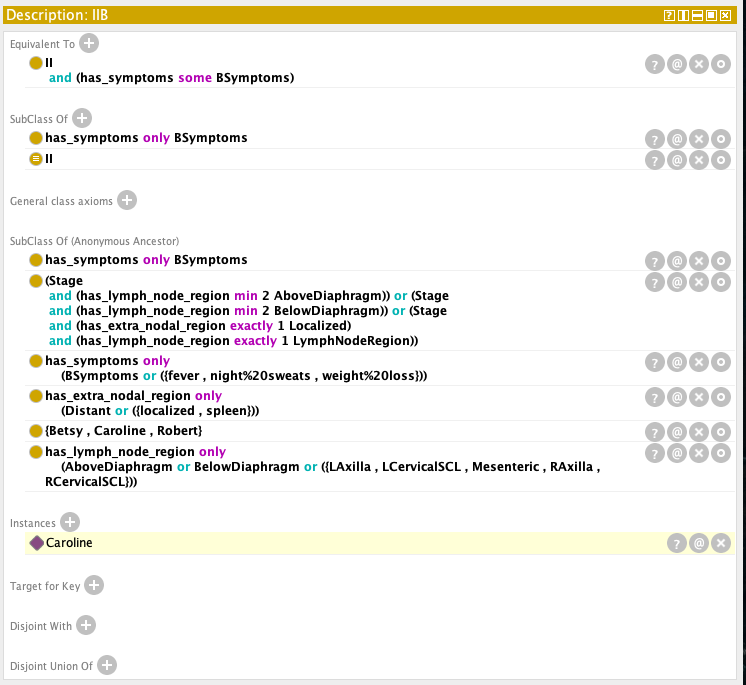

In [98]:
# Caroline was properly inferred as IIB
caroline.set_stage("IIB")

# Robert was properly inferred as IB
robert.set_stage("IB")

# Betsy was properly inferred as III
betsy.set_stage("III")

In [99]:
HodgkinLymphoma(caroline)

Early Classic: Unfavorable


In [100]:
HodgkinLymphoma(betsy)

Late Classic


In [88]:
HodgkinLymphoma(robert)

Early Nodular Lymphocyte Predominate


#### We have correctly inferred the appropriate stage & hydgkin lymphoma type for all three of our patients